Model configuration, data reading and preprocessing

Since the data of trout is also partially missing and does not form a complete time series, many months and years have no observation values. Therefore, referring to some papers and past data, I completed the data using the statistical fitting method with R language.

I used the interpolation method based on the following conditions:

First, determine the time range: monthly data from 2011 to 2018;

Then assume that the average number of trout per net fluctuates between 0 and 1;

Add a smooth sine function to simulate seasonal changes and superimpose a small amount of random perturbation on each monthly value to make it closer to the real situation.

Since the juvenile-mature period of coral trout is mainly calculated based on body length and there is a transformation from female to male within the species, the lag part is not executed in the code.

The "monthly_trout.csv" at the beginning of the code is the already organized raw data.

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

# ------------------ Configuration ------------------
INFILE = "monthly_trout.csv"
HORIZON_MONTHS = 60     # Forecast horizon (months)
LOG_TARGET = True        # Apply log1p transformation to the target
target_col = "MEAN_TROUT_PER_TOW"
env_vars   = ["temp", "salt", "current_speed", "Oxygen", "PH", "Chl"]

#Data Loading & Cleaning
df = pd.read_csv(INFILE)
df.columns = [c.strip().lstrip("\ufeff") for c in df.columns]
if "date" not in df.columns:
    raise KeyError("Missing 'date' column")
df["date"] = pd.to_datetime(df["date"], errors="coerce")
if df["date"].isna().all():
    df["date"] = pd.to_datetime(df["date"].astype(str), format="%Y-%m", errors="coerce")
df = df.sort_values("date")

for c in [target_col] + env_vars:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = (df.set_index("date")
        .replace([np.inf, -np.inf], np.nan)
        .interpolate(limit_direction="both")
        .dropna(subset=[target_col] + env_vars, how="any"))

if len(df) < 24:
    raise ValueError(f"Not enough valid samples ({len(df)}), at least 24 required.")


Standardize environmental data and perform PCA:

After standardizing variables such as temperature, salinity, flow rate, dissolved oxygen, pH, chlorophyll, etc., extract the first two principal components (PC1, PC2) to reduce the dimensionality and capture the main environmental change trends. 

Draw a PCA scatter plot to show the distribution of samples in the PC1 and PC2 spaces, using colors to represent the chronological order, and visually display the changing structure of the environment over time. 

Draw the biplot and add the trout response arrows

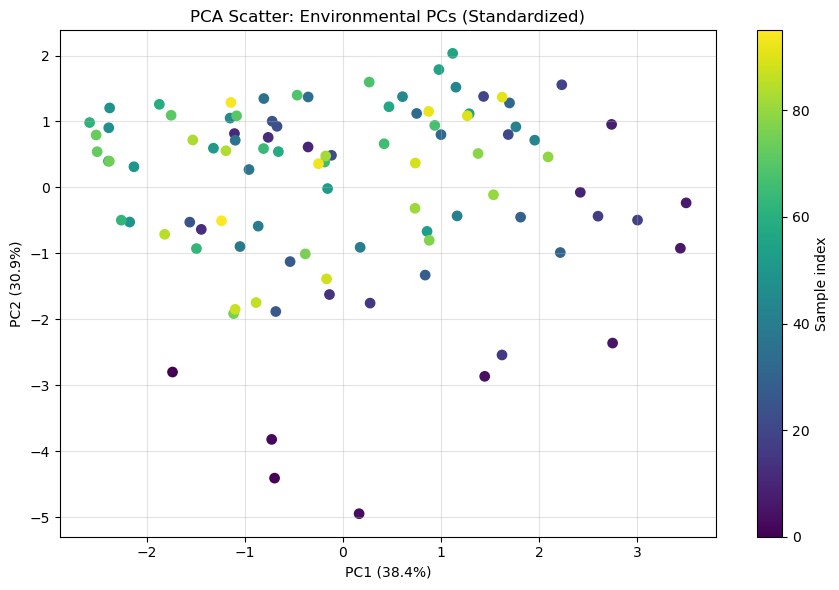

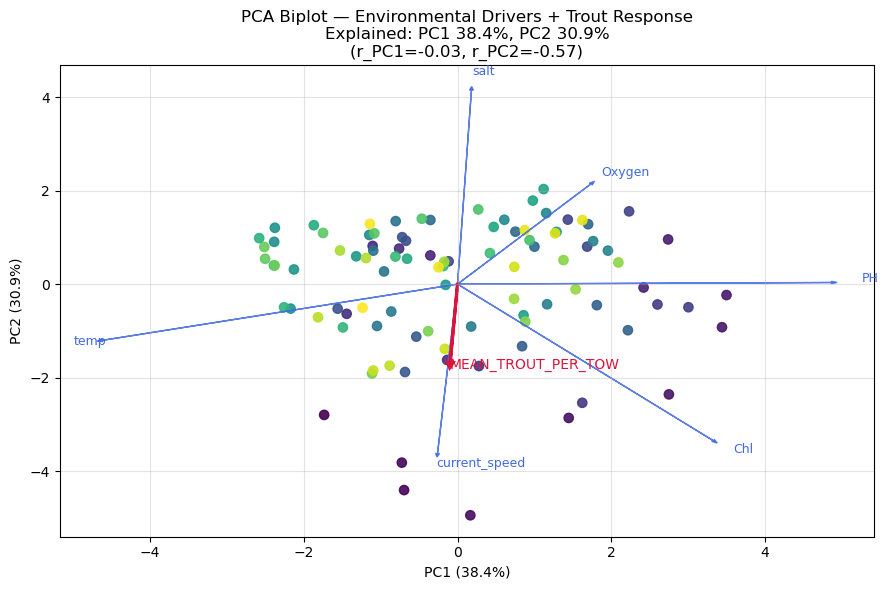

In [68]:
#Environmental PCA (Standardization)
X_env = df[env_vars].copy()
stds = X_env.std()
keep_env = stds[stds > 0].index.tolist()
if len(keep_env) < 2:
    raise ValueError("Less than 2 valid environmental variables, PCA cannot be performed.")

scaler = StandardScaler()
Z_env = scaler.fit_transform(X_env[keep_env].values)
Z_env_df = pd.DataFrame(Z_env, index=X_env.index, columns=keep_env)

pca = PCA(n_components=2, random_state=0)
PC = pca.fit_transform(Z_env_df)
exp = pca.explained_variance_ratio_
pc_df = pd.DataFrame(PC, index=Z_env_df.index, columns=["PC1", "PC2"])
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
load_df = pd.DataFrame(loadings, index=keep_env, columns=["PC1","PC2"])

#Export Data
out_df = df[[target_col]].join(pc_df)
out_df.index.name = "date"
out_df.to_csv("monthly_trout_with_env_PCs.csv", encoding="utf-8")
load_df.to_csv("monthly_trout_env_PCA_loadings.csv", encoding="utf-8")

#Plot: PCA Scatter
plt.figure(figsize=(9,6))
plt.scatter(pc_df["PC1"], pc_df["PC2"], c=np.arange(len(pc_df)), cmap="viridis", s=45)
plt.xlabel(f"PC1 ({exp[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({exp[1]*100:.1f}%)")
plt.title("PCA Scatter: Environmental PCs (Standardized)")
plt.colorbar(label="Sample index")
plt.grid(True, alpha=0.35)
plt.tight_layout()
plt.savefig("PCA_env_scatter.png", dpi=300)
plt.show()

#Plot: PCA Biplot + Trout Response Vector
sx = (pc_df["PC1"].max() - pc_df["PC1"].min()) * 0.8
sy = (pc_df["PC2"].max() - pc_df["PC2"].min()) * 0.8
scale = min(sx, sy) / (np.max(np.abs(loadings)) + 1e-9)

plt.figure(figsize=(9,6))
plt.scatter(pc_df["PC1"], pc_df["PC2"], c=np.arange(len(pc_df)), cmap="viridis", s=45, alpha=0.9)

for var, (lx, ly) in load_df.iterrows():
    dx, dy = lx * scale, ly * scale
    plt.arrow(0, 0, dx, dy, color="royalblue", alpha=0.85, width=0.0, head_width=0.05)
    plt.text(dx*1.08, dy*1.08, var, color="royalblue", fontsize=9)

#Fix KeyError
y = out_df[target_col].reindex(pc_df.index).to_numpy()

r_pc1, p_pc1 = pearsonr(y, pc_df["PC1"].values)
r_pc2, p_pc2 = pearsonr(y, pc_df["PC2"].values)
resp_dx = r_pc1 * (np.max(np.abs(loadings)) * scale) * 0.6
resp_dy = r_pc2 * (np.max(np.abs(loadings)) * scale) * 0.6
plt.arrow(0, 0, resp_dx, resp_dy, color="crimson", lw=2.2, head_width=0.08)
plt.text(resp_dx*1.08, resp_dy*1.08, target_col, color="crimson", fontsize=10)

plt.xlabel(f"PC1 ({exp[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({exp[1]*100:.1f}%)")
plt.title(
    "PCA Biplot — Environmental Drivers + Trout Response\n"
    f"Explained: PC1 {exp[0]*100:.1f}%, PC2 {exp[1]*100:.1f}%\n"
    f"(r_PC1={r_pc1:.2f}, r_PC2={r_pc2:.2f})"
)
plt.grid(True, alpha=0.35)
plt.tight_layout()
plt.savefig("PCA_env_biplot_with_response.png", dpi=300)
plt.show()


Next, the time frequency and seasonal cycles are examined, and the training set and test set are divided: 80% is used for training, and the remaining 20% is used for testing. 

Build and fit the SARIMAX model:
Use the current period's PC1 and PC2 as exogenous variables to fit the SARIMAX model and output the statistical summary. 

Generate test set predictions and confidence intervals:
Based on the model's predictions for the trout population in the test period, convert the results back to the original values (from the log space), and calculate the 95% confidence interval. 

Draw the result graph:
Display the true values, predicted values and confidence interval shadows of the training set and test set on the time axis.

[Freq] Monthly; seasonal s = 12
                                     SARIMAX Results                                      
Dep. Variable:                              y_log   No. Observations:                   76
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                  53.303
Date:                            Thu, 30 Oct 2025   AIC                            -92.606
Time:                                    17:46:12   BIC                            -77.716
Sample:                                01-01-2011   HQIC                           -86.760
                                     - 04-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PC1           -0.0348      0.031     -1.127      0.260      -0.095       0.026
PC2

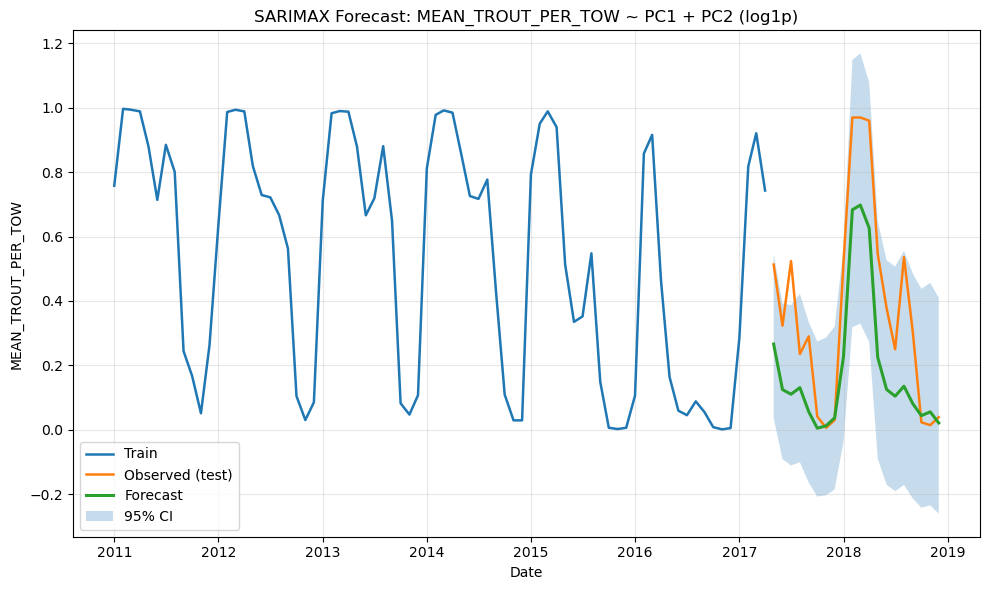

In [69]:
#Construct PCs (no lag) + SARIMAX 
pca_ready = out_df.copy()
pca_ready["y_log"] = np.log1p(pca_ready[target_col]) if LOG_TARGET else pca_ready[target_col]
pca_ready = pca_ready.dropna(subset=["y_log","PC1","PC2"])

dates = pca_ready.index.sort_values()
median_step_days = np.median(np.diff(dates.values).astype("timedelta64[D]").astype(int)) if len(dates)>=3 else 365
is_monthly = median_step_days <= 45
s = 12 if is_monthly else 0
print(f"[Freq] {'Monthly' if is_monthly else 'Yearly'}; seasonal s = {s or 'none'}")

# Split train/test
N = len(pca_ready)
split = max(int(N*0.8), 3)
train = pca_ready.iloc[:split].copy()
test  = pca_ready.iloc[split:].copy()

# Model fitting (use contemporaneous PC1, PC2 as exogenous)
order = (1,0,1)
seasonal_order = (1,0,1,s) if s else (0,0,0,0)
model = SARIMAX(train["y_log"], exog=train[["PC1","PC2"]],
                order=order, seasonal_order=seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False)
res = model.fit(disp=False)
print(res.summary())

# Test set forecasting
fcst = res.get_forecast(steps=len(test), exog=test[["PC1","PC2"]])
pred_log = fcst.predicted_mean
ci = fcst.conf_int()

if LOG_TARGET:
    pred = np.expm1(pred_log)
    ci_lower = np.expm1(ci.iloc[:,0])
    ci_upper = np.expm1(ci.iloc[:,1])
else:
    pred, ci_lower, ci_upper = pred_log, ci.iloc[:,0], ci.iloc[:,1]

plt.figure(figsize=(10,6))
plt.plot(train.index, train[target_col], label="Train", linewidth=1.8)
plt.plot(test.index, test[target_col], label="Observed (test)", linewidth=1.8)
plt.plot(test.index, pred, label="Forecast", linewidth=2.2)
plt.fill_between(test.index, ci_lower, ci_upper, alpha=0.25, label="95% CI")
plt.title("SARIMAX Forecast: MEAN_TROUT_PER_TOW ~ PC1 + PC2 (log1p)")
plt.ylabel(target_col)
plt.xlabel("Date")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("SARIMAX_test_forecast.png", dpi=300)
plt.show()

print("PCA + SARIMAX completed: all plots and CSV files generated.")


We can observe that there were discontinuities during the period from 2017 to 2018, so it is necessary to check whether there is data missing or unidentifiable.

In [70]:
# 1) Check the connection between train and test sets
print("Train:", train.index.min().date(), "→", train.index.max().date())
print("Test :", test.index.min().date(),  "→", test.index.max().date())
gap_days = (test.index.min() - train.index.max()).days
print("Gap between train end and test start (days):", gap_days)

# 2) Check for gaps in the full time axis (>45 days considered a monthly gap)
idx = pca_ready.index.sort_values()
d = pd.Series(idx).diff().dt.days
gaps = d[d > 45]
print("Missing-month gaps (>45 days):")
for i in gaps.index:
    print(f"  {idx[i-1].date()}  →  {idx[i].date()}  ({int(d[i])} days)")


Train: 2011-01-01 → 2017-04-01
Test : 2017-05-01 → 2018-12-01
Gap between train end and test start (days): 30
Missing-month gaps (>45 days):


The training set ended in April 2017, while the test set began in May 2017. 

There is a 30-day (or one-month) interval between the two, which is the normal interval for consecutive monthly data. 

When "Missing-month gaps (>45 days)" is empty, it indicates that there are no missing months in the data. 
Therefore, the breakpoints of this graph are not caused by the time gaps, but rather because the plotting code separately drew two independent curves.

Connect the training set, test set and prediction results into a continuous time series, and generate a gray smooth curve through a three-month moving average.

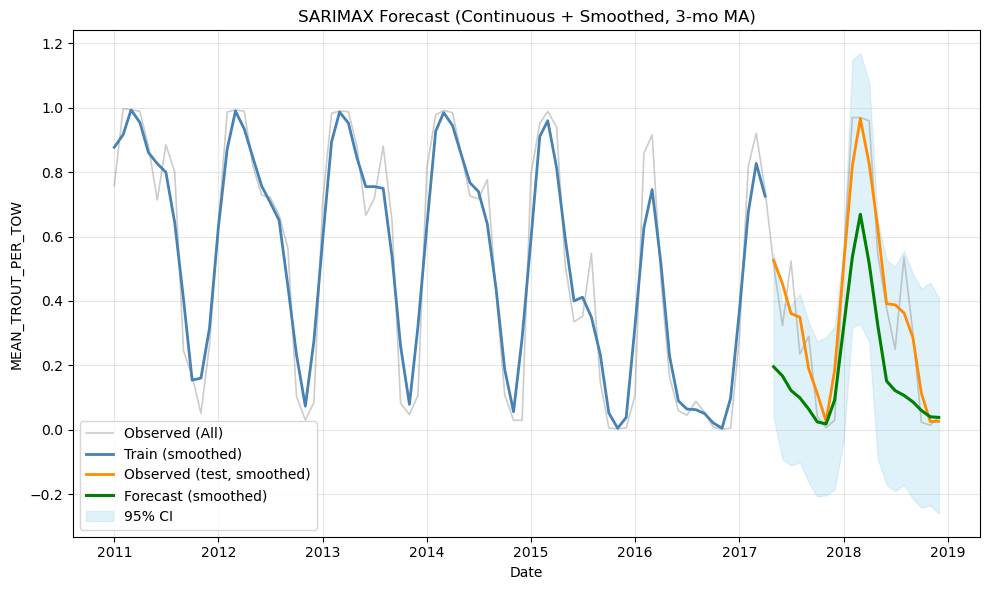

In [71]:
#Continuous & smoothed curve (match figure colors)
all_obs = pd.concat([train[target_col], test[target_col]])

# 3-month centered rolling average for smoothing
smooth_obs = all_obs.rolling(window=3, center=True, min_periods=1).mean()
pred_series = pd.Series(pred, index=test.index)
smooth_pred = pred_series.rolling(window=3, center=True, min_periods=1).mean()

plt.figure(figsize=(10,6))

# Continuous background line (gray)
plt.plot(all_obs.index, all_obs, color="gray", linewidth=1.2, alpha=0.4, label="Observed (All)")

# Smoothed train/test lines
plt.plot(train.index, smooth_obs.loc[train.index], label="Train (smoothed)", color="steelblue", linewidth=2.0)
plt.plot(test.index, smooth_obs.loc[test.index], label="Observed (test, smoothed)", color="darkorange", linewidth=2.0)

# Smoothed forecast (green)
plt.plot(test.index, smooth_pred, label="Forecast (smoothed)", color="green", linewidth=2.2)

# Confidence interval (light blue)
plt.fill_between(test.index, ci_lower, ci_upper, color="skyblue", alpha=0.25, label="95% CI")

plt.title("SARIMAX Forecast (Continuous + Smoothed, 3-mo MA)")
plt.ylabel(target_col)
plt.xlabel("Date")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("SARIMAX_test_forecast_smooth_matched.png", dpi=300)
plt.show()


By using the linear trend of mathematical functions to simulate the trends of temperature increase, salinity decrease, change in ocean current speed, decrease in dissolved oxygen, decrease in pH, and seasonal fluctuations in chlorophyll, environmental variables for the next 60 months (5 years) were constructed, and visualized graphs were output.

✅ Generated future 5-year environmental scenario: future_env_RibReef_5yrs.csv


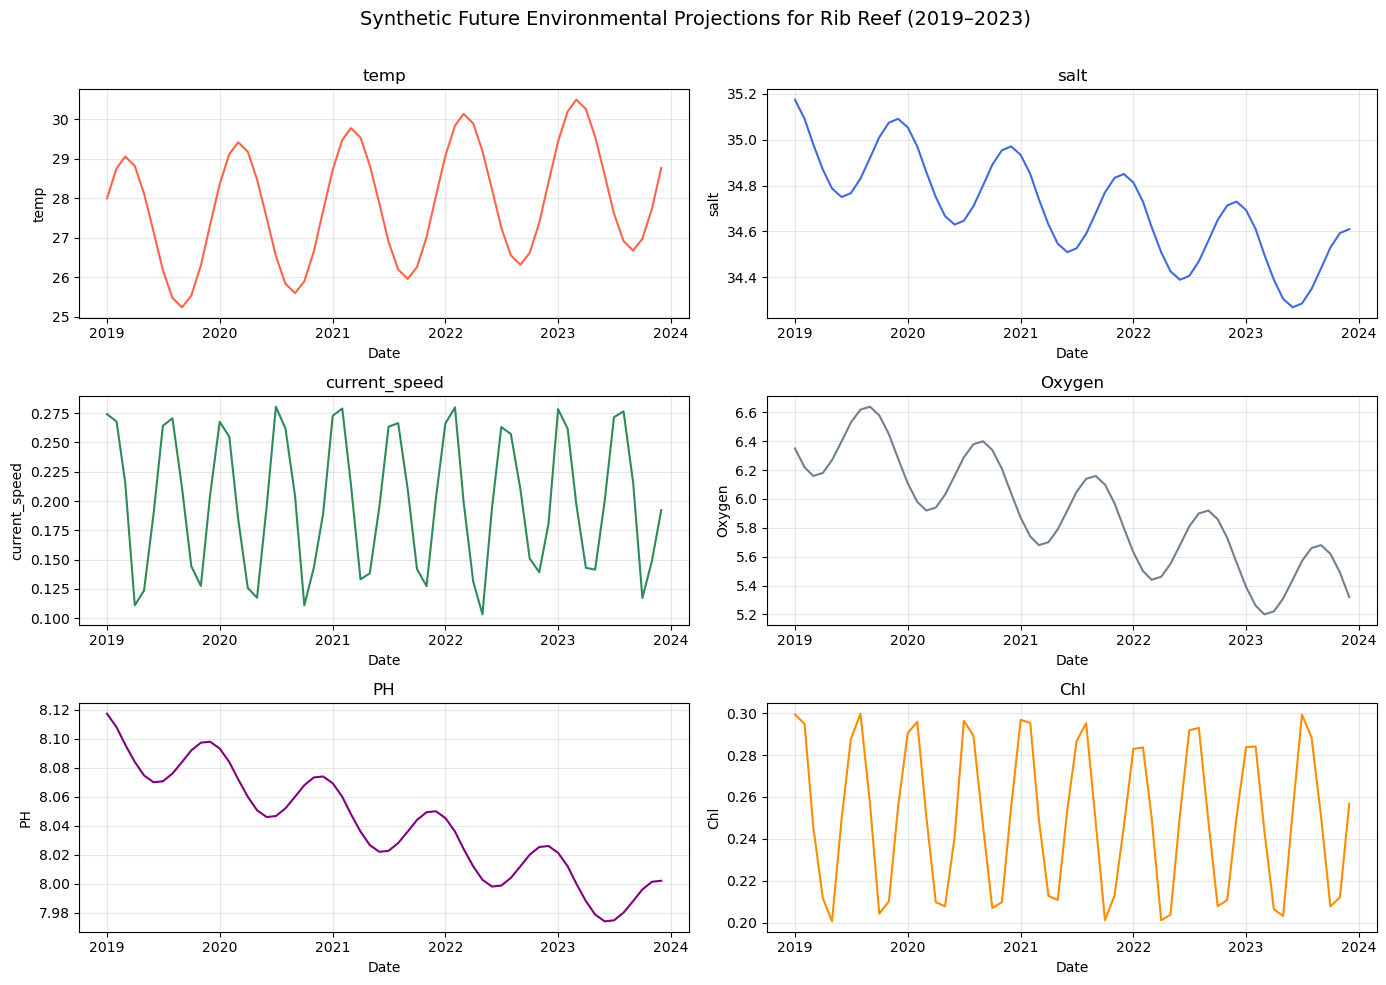

In [72]:
forecast_months = 60  # Next 5 years
last_date = pd.to_datetime("2018-12-01")  # Last observed month in your dataset
future_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(1),
                             periods=forecast_months, freq="MS")

# Simulate climate change trends and seasonal cycles
t = np.arange(forecast_months)
month = future_dates.month

#Temperature: gradual increase + annual cycle
future_temp = 27 + 0.03*t + 2*np.sin(2*np.pi*month/12)

#Salinity: slight decrease (more rainfall and runoff) + annual cycle
future_salt = 35 - 0.01*t + 0.2*np.cos(2*np.pi*month/12)

#Current speed: seasonal variation driven by wind seasons
future_current_speed = 0.20 + 0.08*np.sin(2*np.pi*month/6) + np.random.normal(0, 0.01, size=forecast_months)

#Dissolved oxygen: slight decrease with rising temperature + seasonal signal
future_oxygen = 6.5 - 0.02*t - 0.3*np.sin(2*np.pi*month/12)

#PH: long-term decline (ocean acidification trend)
future_PH = 8.1 - 0.002*t + 0.02*np.cos(2*np.pi*month/12)

#Chlorophyll (Chl): strong seasonal oscillation due to nutrient input
future_Chl = 0.25 + 0.05*np.sin(2*np.pi*month/6) + np.random.normal(0, 0.005, size=forecast_months)

# Combine into a DataFrame
future_env = pd.DataFrame({
    "temp": future_temp,
    "salt": future_salt,
    "current_speed": future_current_speed,
    "Oxygen": future_oxygen,
    "PH": future_PH,
    "Chl": future_Chl
}, index=future_dates)

# Save as file
future_env.to_csv("future_env_RibReef_5yrs.csv", encoding="utf-8")
print("✅ Generated future 5-year environmental scenario: future_env_RibReef_5yrs.csv")

#Visualization (Future environmental variables)
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
axes = axes.flatten()
cols = ["temp", "salt", "current_speed", "Oxygen", "PH", "Chl"]
colors = ["tomato", "royalblue", "seagreen", "slategray", "purple", "darkorange"]

for ax, col, color in zip(axes, cols, colors):
    ax.plot(future_env.index, future_env[col], color=color)
    ax.set_title(col)
    ax.set_xlabel("Date")
    ax.set_ylabel(col)
    ax.grid(alpha=0.3)

plt.suptitle("Synthetic Future Environmental Projections for Rib Reef (2019–2023)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig("future_env_RibReef_plot.png", dpi=300)
plt.show()

First, extract the two main environmental change dimensions (PC1 and PC2). 

Then, use the same standardizer and PCA model to convert the future simulated environmental data into the same principal component space, so that it can be compared with the historical environment in a consistent dimension. 

The final output file is prepared to facilitate the use of the SARIMAX model for predicting the future trout population.

In [73]:

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Load historical data and fit PCA
hist = pd.read_csv("monthly_trout.csv", parse_dates=["date"])
hist = hist.set_index("date").sort_index()
target_col = "MEAN_TROUT_PER_TOW"
env_vars = ["temp", "salt", "current_speed", "Oxygen", "PH", "Chl"]

# Data cleaning
hist = (hist.replace([np.inf, -np.inf], np.nan)
            .interpolate(limit_direction="both")
            .dropna(subset=[target_col] + env_vars, how="any"))

#Fit standardization + PCA
scaler = StandardScaler()
Z_hist = scaler.fit_transform(hist[env_vars])
pca = PCA(n_components=2, random_state=0)
pca.fit(Z_hist)

# Map historical data into PCA space (for verification)
PC_hist = pca.transform(Z_hist)
hist_pc = pd.DataFrame(PC_hist, index=hist.index, columns=["PC1", "PC2"])
hist_pc["MEAN_TROUT_PER_TOW"] = hist[target_col]

#Apply PCA transformation to future environment data
Z_future = scaler.transform(future_env[env_vars])
future_PC = pca.transform(Z_future)
future_pc = pd.DataFrame(future_PC, index=future_env.index, columns=["PC1", "PC2"])

# Save future PCA results
future_pc.to_csv("future_PC_RibReef_5yrs.csv", encoding="utf-8")
print("✅ Future principal component file generated: future_PC_RibReef_5yrs.csv")


✅ Future principal component file generated: future_PC_RibReef_5yrs.csv


Using the pre-trained SARIMAX model, based on the environmental principal components (PC1, PC2) for the next 5 years, predict the changes in trout population and generate corresponding charts and result files.

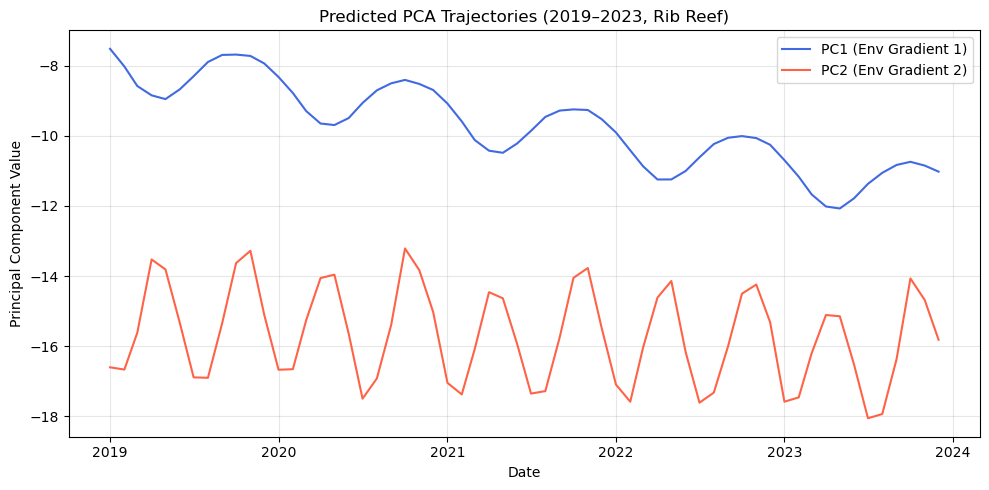

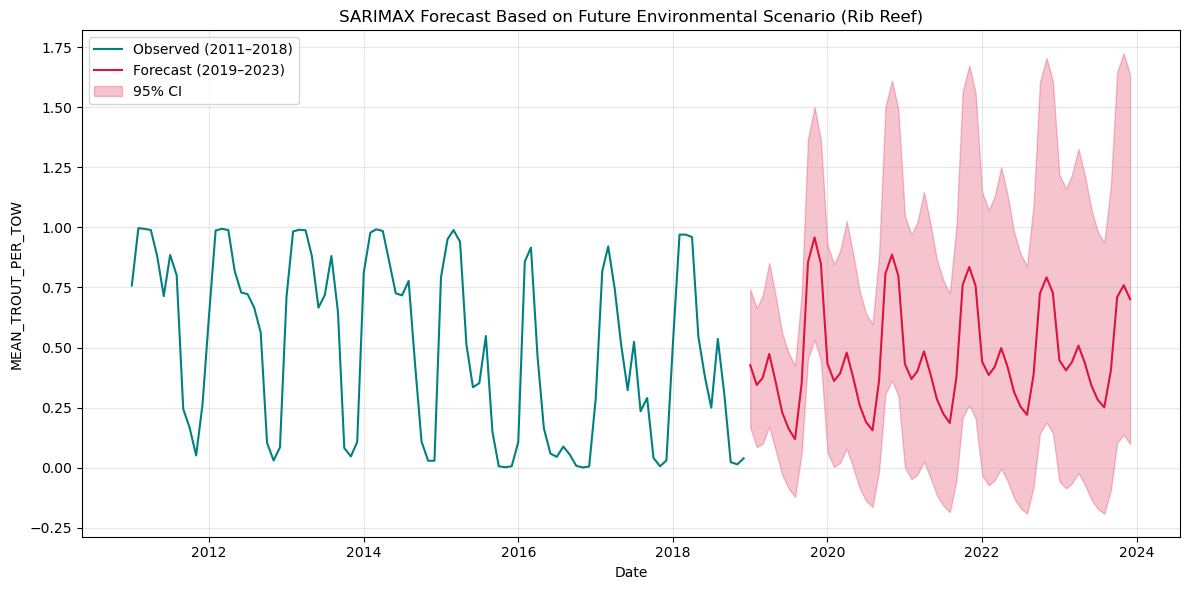

Forecast completed:
 - future_PC_RibReef_5yrs.csv (future principal components)
 - Future_Trout_Predictions_RibReef.csv (predicted trout results)
 - Future_Trout_Forecast_RibReef.png (forecast plot)


In [74]:

# Forecast (using contemporaneous PCs instead of lagged PCs)
forecast_steps = len(future_pc)
fcst = res.get_forecast(steps=forecast_steps, exog=future_pc[["PC1", "PC2"]])
pred_mean_future = np.expm1(fcst.predicted_mean)
pred_ci_future = np.expm1(fcst.conf_int())

#Visualize future PCA trends
plt.figure(figsize=(10,5))
plt.plot(future_pc.index, future_pc["PC1"], label="PC1 (Env Gradient 1)", color="royalblue")
plt.plot(future_pc.index, future_pc["PC2"], label="PC2 (Env Gradient 2)", color="tomato")
plt.xlabel("Date")
plt.ylabel("Principal Component Value")
plt.title("Predicted PCA Trajectories (2019–2023, Rib Reef)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("future_PC_RibReef_plot.png", dpi=300)
plt.show()

#Visualize predicted trout abundance
plt.figure(figsize=(12,6))
plt.plot(hist_pc.index, hist_pc["MEAN_TROUT_PER_TOW"], label="Observed (2011–2018)", color="teal")
plt.plot(future_pc.index, pred_mean_future, label="Forecast (2019–2023)", color="crimson")
plt.fill_between(future_pc.index,
                 pred_ci_future.iloc[:,0],
                 pred_ci_future.iloc[:,1],
                 color="crimson", alpha=0.25, label="95% CI")
plt.xlabel("Date")
plt.ylabel("MEAN_TROUT_PER_TOW")
plt.title("SARIMAX Forecast Based on Future Environmental Scenario (Rib Reef)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("Future_Trout_Forecast_RibReef.png", dpi=300)
plt.show()

#Export prediction results
out_future = pd.DataFrame({
    "date": future_pc.index,
    "Predicted_MEAN_TROUT_PER_TOW": pred_mean_future.values,
    "CI_lower": pred_ci_future.iloc[:,0].values,
    "CI_upper": pred_ci_future.iloc[:,1].values,
    "PC1": future_pc["PC1"].values,
    "PC2": future_pc["PC2"].values
})
out_future.to_csv("Future_Trout_Predictions_RibReef.csv", index=False, encoding="utf-8")

print("Forecast completed:")
print(" - future_PC_RibReef_5yrs.csv (future principal components)")
print(" - Future_Trout_Predictions_RibReef.csv (predicted trout results)")
print(" - Future_Trout_Forecast_RibReef.png (forecast plot)")


Also due to the way the data is plotted, there is a break between the observed values and the predicted values. A gray line is added between the observation period and the prediction period to represent a "bridge", allowing the two curves to visually connect seamlessly.

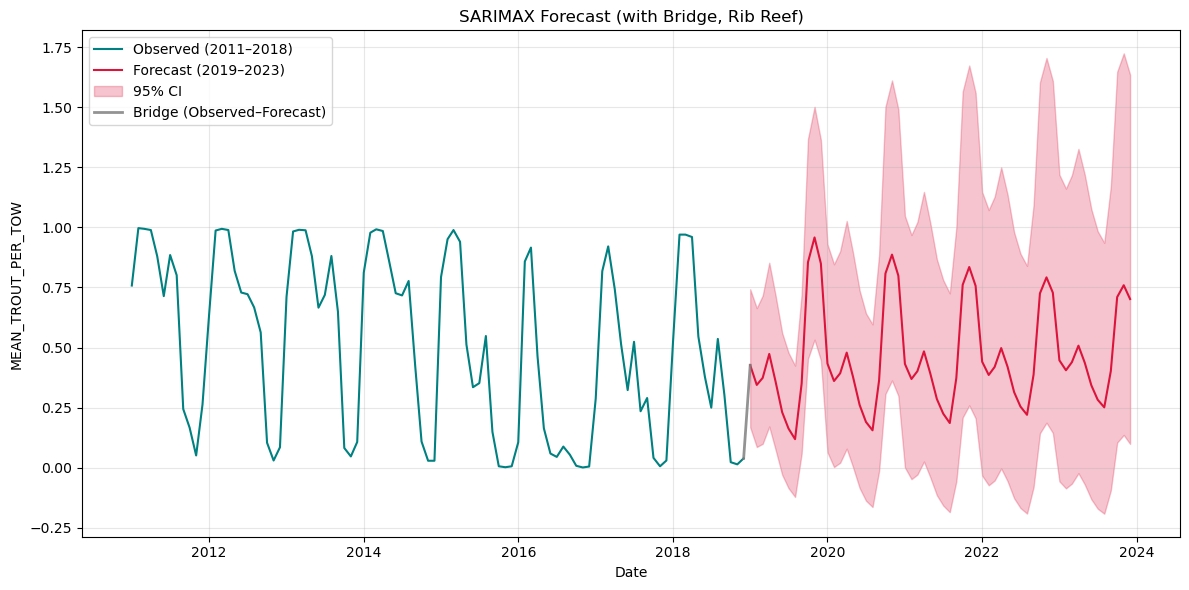

In [75]:
#New figure with gray bridge; original main figure unchanged
prev_idx = hist_pc.index.max()              # last observed date
next_idx = future_pc.index.min()            # first forecast date
y_prev   = hist_pc["MEAN_TROUT_PER_TOW"].loc[prev_idx]
y_next   = pred_mean_future.iloc[0]

plt.figure(figsize=(12,6))
#replot original elements
plt.plot(hist_pc.index, hist_pc["MEAN_TROUT_PER_TOW"], label="Observed (2011–2018)", color="teal")
plt.plot(future_pc.index, pred_mean_future, label="Forecast (2019–2023)", color="crimson")
plt.fill_between(future_pc.index,
                 pred_ci_future.iloc[:,0], pred_ci_future.iloc[:,1],
                 color="crimson", alpha=0.25, label="95% CI")

#add the gray bridge to close the visual gap
plt.plot([prev_idx, next_idx], [y_prev, y_next],
         color="gray", linewidth=2.0, alpha=0.85, label="Bridge (Observed–Forecast)")

plt.xlabel("Date")
plt.ylabel("MEAN_TROUT_PER_TOW")
plt.title("SARIMAX Forecast (with Bridge, Rib Reef)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("Future_Trout_Forecast_RibReef_with_bridge.png", dpi=300)
plt.show()
